# Typical LSTM & GRU Architectures for Time Series

In [20]:
import numpy as np
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt

# Supportive functions 

In [11]:
# Configurable parameters
CONFIG = {
    "total_points": 1000,
    "train_split": 0.8,
    "time_steps": 20,  # Used for windowing
    "batch_size": 32,
    "seq_to_seq": not True,  # If False, does seq-to-vector
    "noise_std": 0.1,
    "seed": 42,
    "stride": 1,  # Window shift
    "n_features": 1,  # Number of features
}

np.random.seed(CONFIG["seed"])
tf.random.set_seed(CONFIG["seed"])

## Generate Synthetic Time Series Data

In [12]:
def generate_time_series(total_points, noise_std=0.1, n_features=1):
    t = np.linspace(0, 50, total_points)
    features = []
    for i in range(n_features):
        phase = i * np.pi / 4
        freq = 1 + 0.2 * i
        y = np.sin(freq * t + phase) + np.random.normal(0, noise_std, size=total_points)
        features.append(y)
    y = np.stack(features, axis=-1)  # shape: (total_points, n_features)
    return t, y

In [13]:
def plot_time_series(t, y, title="Synthetic Time Series Data"):
    plt.figure(figsize=(12, 4))
    for i in range(y.shape[1]):
        plt.plot(t, y[:, i], label=f"Feature {i}")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

In [14]:
t, y = generate_time_series(CONFIG["total_points"], CONFIG["noise_std"], CONFIG["n_features"])

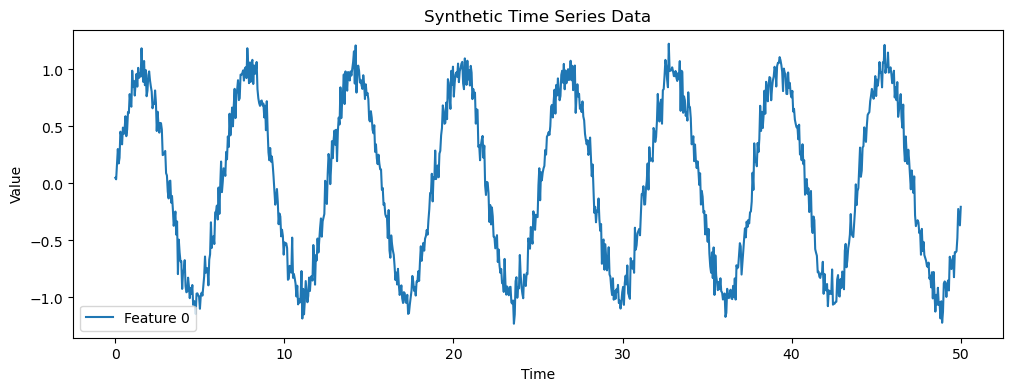

In [15]:
plot_time_series(t, y)

## Data Windowing Functions for Typologies

In [21]:
def create_windows(y, time_steps, typology='seq2seq', stride=1):
    X, Y = [], []
    for i in range(0, len(y) - time_steps, stride):
        if typology == 'seq2seq':
            X.append(y[i:i+time_steps])
            Y.append(y[i+1:i+time_steps+1])
        elif typology == 'seq2val':
            X.append(y[i:i+time_steps])
            Y.append(y[i+time_steps])
        elif typology == 'val2seq':
            X.append(y[i])
            Y.append(y[i+1:i+time_steps+1])
    X = np.array(X)
    Y = np.array(Y)
    return X, Y

## Prepare Data for Each Typology

In [22]:
# Sequence-to-Sequence
X_seq2seq, Y_seq2seq = create_windows(y, CONFIG['time_steps'], 'seq2seq', CONFIG['stride'])
# Sequence-to-Value
X_seq2val, Y_seq2val = create_windows(y, CONFIG['time_steps'], 'seq2val', CONFIG['stride'])
# Value-to-Sequence
X_val2seq, Y_val2seq = create_windows(y, CONFIG['time_steps'], 'val2seq', CONFIG['stride'])

## 1. Stacked LSTM/GRU Architectures

In [24]:
# Stacked LSTM for seq-to-seq
def build_stacked_lstm_seq2seq(input_shape, output_shape):
    model = models.Sequential([
        layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        layers.LSTM(32, return_sequences=True),
        layers.TimeDistributed(layers.Dense(output_shape[-1]))
    ])
    return model

In [25]:
# Stacked GRU for seq-to-value
def build_stacked_gru_seq2val(input_shape, output_dim):
    model = models.Sequential([
        layers.GRU(64, return_sequences=True, input_shape=input_shape),
        layers.GRU(32),
        layers.Dense(output_dim)
    ])
    return model

In [ ]:
print('Stacked LSTM (seq-to-seq):')
model_lstm_seq2seq = build_stacked_lstm_seq2seq(X_seq2seq.shape[1:], Y_seq2seq.shape[1:])
model_lstm_seq2seq.summary()

Stacked LSTM (seq-to-seq):


/opt/conda/envs/py39_tensorflow/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 1)          │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
print('\nStacked GRU (seq-to-value):')
model_gru_seq2val = build_stacked_gru_seq2val(X_seq2val.shape[1:], Y_seq2val.shape[-1])
model_gru_seq2val.summary()


Stacked GRU (seq-to-value):


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 20, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,305 (87.13 KB)

 Trainable params: 22,305 (87.13 KB)

 Non-trainable params: 0 (0.00 B)

## 2. Bidirectional LSTM/GRU Architectures

In [1]:
# Bidirectional LSTM for value-to-seq
def build_bidir_lstm_val2seq(input_dim, output_shape):
    i = layers.Input(shape=(input_dim,))
    x = layers.RepeatVector(output_shape[0])(i)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)
    out = layers.TimeDistributed(layers.Dense(output_shape[1]))(x)
    return models.Model(i, out)

In [29]:
# Bidirectional GRU for seq-to-seq
def build_bidir_gru_seq2seq(input_shape, output_shape):
    model = models.Sequential([
        layers.Bidirectional(layers.GRU(32, return_sequences=True), input_shape=input_shape),
        layers.TimeDistributed(layers.Dense(output_shape[-1]))
    ])
    return model

In [ ]:
print('Bidirectional LSTM (value-to-seq):')
model_bidir_lstm_val2seq = build_bidir_lstm_val2seq(X_val2seq.shape[-1], Y_val2seq.shape[1:])
model_bidir_lstm_val2seq.summary()

Bidirectional LSTM (value-to-seq):


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 20, 64)         │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,769 (34.25 KB)

 Trainable params: 8,769 (34.25 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
print('\nBidirectional GRU (seq-to-seq):')
model_bidir_gru_seq2seq = build_bidir_gru_seq2seq(X_seq2seq.shape[1:], Y_seq2seq.shape[1:])
model_bidir_gru_seq2seq.summary()


Bidirectional GRU (seq-to-seq):


/opt/conda/envs/py39_tensorflow/lib/python3.9/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 20, 64)         │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,785 (26.50 KB)

 Trainable params: 6,785 (26.50 KB)

 Non-trainable params: 0 (0.00 B)